### MNISTの分類

* MNISTは数字分類のデータセット
* 機械学習の分野で一番有名なデータセット
* 簡単な問題で、単純な手法で精度が90%以上
* 最近のパソコンで数分で学習可能

#### 課題

1. コードを動かしてみて、下記の質問に答えよう

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import random
from tqdm import tqdm

#### モデルの定義

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # 1枚を２０枚に変換
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10) #全結合層

    def forward(self, x): # x:batch  
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) # 半分
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50) # 全結合の前にベクトルのサイズに変換
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#### データ

In [0]:
Dtrain = datasets.MNIST('../data', train=True, download=True )
Dtest  = datasets.MNIST('../data', train=False, download=True )

In [4]:
Dmean = torch.tensor( list( map( lambda x: transforms.ToTensor()(x[0]).mean(), Dtrain ) ) ).mean()
Dstd = torch.tensor( list( map( lambda x: transforms.ToTensor()(x[0]).std(), Dtrain ) ) ).mean()
print( "Data: %.3f (%.3f)" % (Dmean, Dstd))

Data: 0.131 (0.302)


In [0]:
idx = list(range(len(Dtrain)))
random.shuffle(idx)
idx = idx[0:10000]
split = 100
train_idx, valid_idx = idx[split:], idx[:split]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

Dtransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((Dmean,), (Dstd,))
])
Dtrain = datasets.MNIST('../data', train=True,  transform=Dtransform )
Dtest  = datasets.MNIST('../data', train=False, transform=Dtransform )

batchsize = 128
train_loader = torch.utils.data.DataLoader( Dtrain, batch_size=batchsize, sampler=train_sampler )
valid_loader = torch.utils.data.DataLoader( Dtrain, batch_size=batchsize, sampler=valid_sampler )
test_loader  = torch.utils.data.DataLoader( Dtest,  batch_size=batchsize )

#### モデル、ロス関数、最適化手法

In [0]:
device = torch.device("cuda" if torch.cuda.device_count()>0 else "cpu")
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

#### 学習ループ

In [0]:
epoch_train_loss = []
epoch_valid_loss = []

In [8]:
for epoch in range(10):
    model.train()
    running_loss = 0
    for x,y in tqdm(train_loader, desc=("Epoch %d"%(epoch+1))):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = F.nll_loss( pred, y )
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    epoch_train_loss.append( running_loss/len(train_loader) )
            
    model.eval()
    with torch.no_grad():
        running_loss = 0
        for x,y in valid_loader:
            x,y = x.to(device), y.to(device)
            pred = model(x)
            loss = F.nll_loss( pred, y )
            running_loss += loss.item()    
    epoch_valid_loss.append( running_loss/len(valid_loader) )

Epoch 10: 100%|██████████| 78/78 [00:08<00:00,  9.53it/s]


#### テスト

In [9]:
model.eval()
with torch.no_grad():
    correct = 0
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax( dim=1, keepdim=True )
        correct += pred.eq( y.view_as(pred) ).sum().item()
print( correct / len(test_loader.dataset) )

0.8163


#### プロット

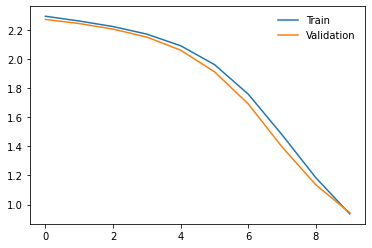

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot( epoch_train_loss, label='Train')
plt.plot( epoch_valid_loss, label='Validation')
plt.legend(frameon=False)

#### モデルを変えよう

In [0]:
# poolingの代わりにストライド
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d( 1, 16, 3, stride=2, padding=1),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.Conv2d(32, 32, 3, stride=1, padding=1)
        ])
        self.fc1 = nn.Linear(4*4*32, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        for c in self.conv:
            x = F.relu( c(x) )
        x = x.view(-1, 4*4*32)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
# 全層畳み込みそう, Global Average Pooling # Global Average Poolingってどんなときに使われるモデルですか？

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(  1,  16, 3, stride=2, padding=1),
            nn.Conv2d( 16,  32, 3, stride=2, padding=1),
            nn.Conv2d( 32,  64, 3, stride=2, padding=1),
            nn.Conv2d( 64, 128, 3, stride=2, padding=1),
            nn.Conv2d(128, 128, 3, stride=2, padding=1)
        ])
        self.last = nn.Conv2d( 128, 10, 3, stride=1, padding=1 )

    def forward(self, x):
        for c in self.conv:
            x = F.relu( c(x) )
        x = self.last(x)
        x = F.avg_pool2d( x, 4 ).view(-1,10)
        return F.log_softmax(x, dim=1)

### 質問

1. 反転、クロップなどのtransformを使うとどうなる？なぜ？（参考： https://pytorch.org/docs/stable/torchvision/transforms.html ）
1. どうして検証セットが必要？
1. .zero_gradはどうして必要？どこで使うべき？

##### 補足: モデルのビジュアライゼーション

https://github.com/waleedka/hiddenlayer

##### インストール

````
conda install graphviz python-graphviz
pip install hiddenlayer
````

In [18]:
%%bash 

#conda install graphviz python-graphviz
pip install hiddenlayer

bash: line 2: conda: command not found


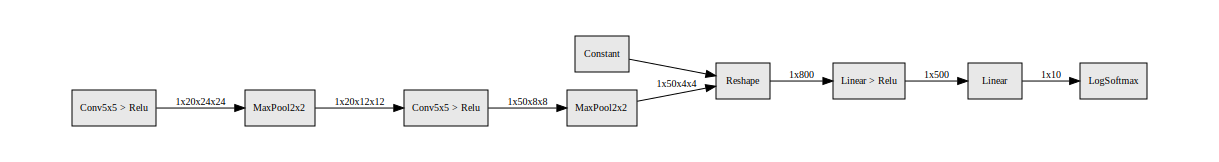

In [19]:
import hiddenlayer as hl
hl.build_graph(model.to('cpu'), torch.zeros([1, 1, 28, 28]))

In [20]:
!pip install hiddenlayer